In [91]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
import openmc_source_plotter
import plotly.graph_objects as go
from math import cos, pi

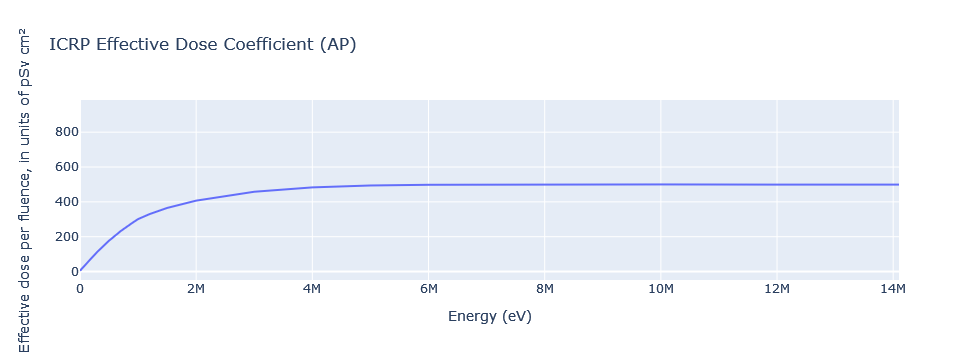

In [92]:
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(
    particle='neutron', geometry='AP')

fig = go.Figure()

fig.update_layout(
      title='ICRP Effective Dose Coefficient (AP)',
      xaxis={'title': 'Energy (eV)',
             'range': (0, 14.1e6)},
      yaxis={'title': 'Effective dose per fluence, in units of pSv cm²'}
)



fig.add_trace(go.Scatter(
    x=energy_bins_n,
    y=dose_coeffs_n,
    mode='lines',
    name='neutron'
))

In [93]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
#ground_material = nmm.Material.from_library("concrete_heavy").openmc_material
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

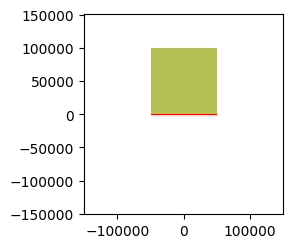

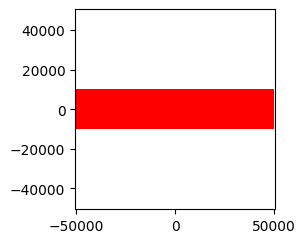

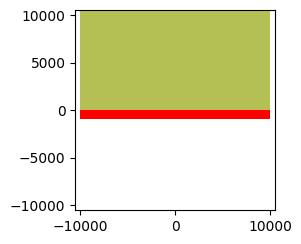

In [94]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, 0, 100000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, -1000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-50001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-10001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(300100, 301100), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(101100, 101100), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='yz', colors=color_assignment))

In [95]:
def sim_sett(ww):
    #create the source
    sett = openmc.Settings()
    sett.particles = 10000000
    sett.batches = 4
    sett.inactive = 0
    sett.run_mode = 'fixed source'
    sett.weight_windows = ww

    source = openmc.Source()
    source.particle = 'neutron'
    source.energy = openmc.stats.Discrete([19e6], [1])

    mu = openmc.stats.Uniform(cos(pi/5), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
    source.space = openmc.stats.Point((0,0,5000))
    sett.source = source
    
    #%matplotlib inline
    #plot = source.plot_source_direction()
    #plot.show()
    
    sett.export_to_xml()
    return sett

In [96]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [1000,1,1]
air_mesh.lower_left = [-50000,-10000, 0]

air_mesh.upper_right = [50000,10000, 100]

mesh_filter = openmc.MeshFilter(air_mesh)
#air_mesh.vertices

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning:

Another MeshBase instance already exists with id=1.



In [100]:
pwd

'/root/OpenMC/openmc/ISIS/Skyshine'

In [106]:
#implement weight windows
from weight_windows_values import upper_ww_bounds, lower_ww_bounds
ww = openmc.WeightWindows(
    mesh=air_mesh,
    upper_ww_bounds=upper_ww_bounds,
    lower_ww_bounds=lower_ww_bounds,
    particle_type='neutron',
    energy_bounds=(0.0, 100000000.),  # applies this weight window to neutrons of within a large energy range (basically all neutrons in the simulation)
    survival_ratio=5
)

ValueError: cannot reshape array of size 15625 into shape (1000,1,1,1)

In [ ]:
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
#energy_function_filter_n.interpolation == 'cubic'
neutron_particle_filter = openmc.ParticleFilter(['neutron'])

In [ ]:
#tally
tallies = openmc.Tallies()
shine_dose_tally = openmc.Tally(name='shine_dose_tally')
shine_dose_tally.scores  = ['flux']
shine_dose_tally.filters = [mesh_filter, neutron_particle_filter, energy_function_filter_n]
tallies.append(shine_dose_tally)
tallies.export_to_xml()

In [ ]:
#look at current through mesh surface
surf_mesh_filter = openmc.MeshSurfaceFilter(air_mesh)
mesh_current_tally = openmc.Tally(name='mesh_current_tally')
mesh_current_tally.scores = ['current']
mesh_current_tally.filters = [surf_mesh_filter, neutron_particle_filter]
tallies.append(mesh_current_tally)

In [ ]:
settings = sim_sett(ww)
model = openmc.model.Model(geom, mats, settings, tallies)
!rm *.h5
results_filename = model.run(threads=8)
    
results = openmc.StatePoint(results_filename)
flux_tally = results.get_tally(name="shine_dose_tally")
df_dose = flux_tally.get_pandas_dataframe()
mesh_curr_tally = results.get_tally(name="mesh_current_tally")

results.close()

In [ ]:
mesh_vol = 1*20
distance_x = air_mesh.vertices[:,0,0,0]


In [ ]:
df_curr = mesh_curr_tally.get_pandas_dataframe()
df_curr.iloc[0:12]

In [ ]:

flux = df[df['score'] == 'flux']
flux_mean = (flux["mean"] / mesh_vol)
flux_std = (flux["std. dev."] / mesh_vol) 
plt.errorbar(distance_x[:-1]/100, flux_mean/10**6, flux_std/10**6,ls='None', marker='x')
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("Dose ($\mu$Sv per Pulse) ")
plt.axvline(x=0, ls='--', color='black')
plt.xlim(-1,100)
plt.ylim(5e-7,8e-7)
#plt.yscale('log')

#plot flux as function of energy
flux_array = np.array(flux_list)
flux_array
np.max(df_list[0]["mean"])

In [ ]:
plt.loglog(angles, max_means, color='b', ls=None, marker='x')
plt.xlabel(r"Angle $\theta$ of distribution")
plt.ylabel("Flux p/sp per cm2")
plt.title("Flux as function of angular distribution")

In [ ]:
curr = df_curr[df_curr['score'] == 'current']
curr_mean = (curr["mean"] / mesh_vol)
curr_std = (curr["std. dev."] / mesh_vol) 
len(distance_x)

In [ ]:

plt.errorbar(distance_x[:-1]/100, curr_mean/10**6, curr_std/10**6,ls='None', marker='x')
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("Dose ($\mu$Sv per Pulse) ")